Implementing "Error suppression in Hamiltonian-based quantum computation using energy penalties" paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [6]:
# Number of qubits in the environment and system
n_env = 1
n_system = 4

# Time parameters
T = 10000  # Total time
timesteps = np.linspace(0, T, 10000)

# Random coefficients for the environment Hamiltonian and couplings
alpha = np.random.uniform(0.9, 1.1, size=n_env)
alpha_bc = np.random.uniform(0.9, 1.1, size=(n_env, n_env))
beta = np.random.uniform(0.9, 1.1, size=n_system)
gamma = np.random.uniform(0.9, 1.1, size=n_system)

# Pauli matrices for system and environment qubits
pauli_matrices = [sigmax(), sigmay(), sigmaz()]


In [7]:
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

eye_env = tensor([I for _ in range(n_env)])
eye_sys = tensor([I for _ in range(n_system)])

# Define the stabilizer generators for the 4-qubit bit-flip code
g1 = tensor(X, X, X, X)
g2 = tensor(Z, Z, Z, Z)
g3 = tensor(X, Y, Z, I)

stabilizers = [
    g1,
    g2,
    g3
]

X_L = tensor(Y, I, Y, I)
Z_L = tensor(Z, Z, I, I)
Y_L = -tensor(I, X, X, I)


basis_states = [basis(2, 0), basis(2, 1)]

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                1j*tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                1j*tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

logical_one = X_L * logical_zero


# Define projection operators
P0 = logical_zero * logical_zero.dag()
P1 = logical_one * logical_one.dag()
P_tot = P0 + P1


In [8]:
# Define random unit vectors for system and environment qubits
def random_unit_vector():
    vec = np.random.randn(3)
    return vec / np.linalg.norm(vec)

n_system_vecs = [random_unit_vector() for _ in range(n_system)]
n_env_vecs = [random_unit_vector() for _ in range(n_env)]


# Environment Hamiltonian
H_env = 0
for a in range(n_env):
    # Single-qubit terms
    H_env += alpha[a] * sum([n_env_vecs[a][i] * tensor([pauli_matrices[i] if j == a else qeye(2) for j in range(n_env)]) for i in range(3)])


# Add two-local interactions between neighboring qubits on the three-regular graph
for b in range(n_env):
    for c in range(b + 1, n_env):
        # Random unit vectors for the two-qubit interaction
        mb = random_unit_vector()
        mc = random_unit_vector()
        
        # Two-local interaction
        H_env += alpha_bc[b, c] * sum([mb[i] * mc[i] * tensor([pauli_matrices[i] if j == b or j == c else qeye(2) for j in range(n_env)]) for i in range(3)])
        
# System-Environment coupling Hamiltonian V
V = 0
for s in range(n_system):
    # Single qubit error terms acting only on system qubits
    V += beta[s] * sum([n_system_vecs[s][i] * tensor(
        [pauli_matrices[i] if j == s else qeye(2) for j in range(n_system)] +  # System qubits
        [qeye(2) for _ in range(n_env)]  # Identity for environment qubits
    ) for i in range(3)])

    # System-environment coupling terms
    for a in range(n_env):
        # Build the tensor product for system qubit s and environment qubit a
        V += gamma[s] * sum([n_system_vecs[s][i] * tensor(
            [pauli_matrices[i] if j == s else qeye(2) for j in range(n_system)] +  # System qubits
            [pauli_matrices[i] if j == a else qeye(2) for j in range(n_env)]  # Environment qubits
        ) for i in range(3)])

psi_s = logical_zero.unit()

# Random pure state for the environment
# Create a random complex vector of size 2^n_env
random_complex_vector = (np.random.randn(2**n_env) + 1j * np.random.randn(2**n_env))

# Normalize the vector to make it a valid quantum state
random_complex_vector /= np.linalg.norm(random_complex_vector)

psi_e = Qobj(random_complex_vector, dims=[[2]*n_env, [1]*n_env])

# Full initial state: system + environment
psi_initial = tensor(psi_s, psi_e)

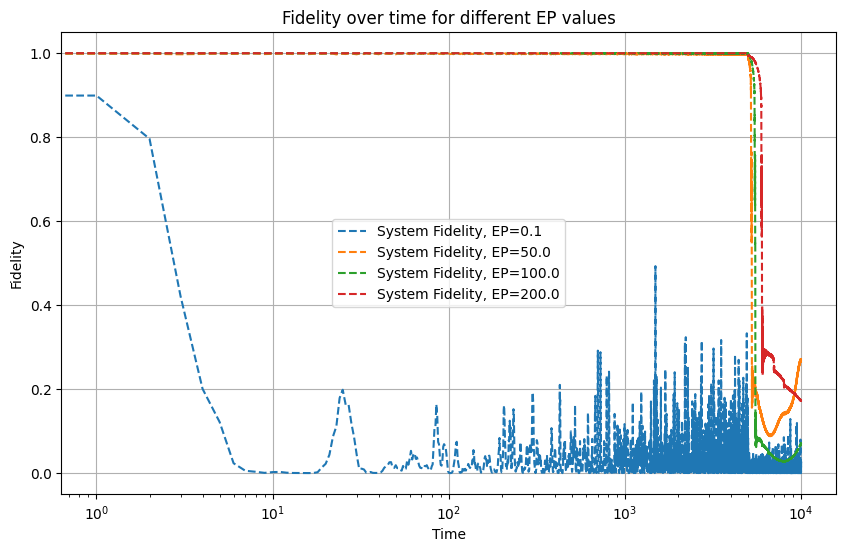

In [34]:
# Simulate for different EP values
E_P_values = [0.1, 50.0, 100.0, 200.0]
fidelities_total = []
fidelities_system = []

# Time parameters
T = 10000  # Total time
timesteps = np.linspace(0, T, T)

# Coupling constant lambda
lambda_value = 0.1

sigma = 1
omega_max = 50
H_S_t = QobjEvo([[X_L, lambda tau: omega_max * np.exp(-0.5 * ((tau - T/2) / sigma) ** 2)],
                 [Z_L, lambda tau: 2 * omega_max * (tau / (T/2) - 1)]])

H_system_expanded = tensor(H_S_t, eye_env)
H_env_expanded = tensor(eye_sys, H_env)


for E_P in E_P_values:
    
    Hp = -E_P*(g1 + g2 + g3)
    
    H_total = H_system_expanded + H_env_expanded + lambda_value * V + lambda_value * tensor(Hp, eye_env)
    # H_total = H_system_expanded + H_env_expanded
    
    # Solve the Schrödinger equation with the full Hamiltonian
    result_coupled = sesolve(H_total, psi_initial, timesteps)
    
    # Solve the Schrödinger equation without the coupling (only the system evolution)
    result_uncoupled = sesolve(H_S_t, psi_s, timesteps)
    
    # Fidelity measures
    F2_total = []
    F2_system = []
    for t in range(len(timesteps)):
        # Total fidelity (including the environment)
        phi_t_coupled = result_coupled.states[t]
        phi_t_uncoupled = tensor(result_uncoupled.states[t], psi_e)
        
        # Calculate the overlap and handle the scalar case
        overlap_total = phi_t_uncoupled.dag() * phi_t_coupled
        F2_total.append(abs(overlap_total)**2)
    
        # System fidelity (tracing out the environment)
        rho_t = phi_t_coupled.ptrace(list(range(n_system)))  # Trace out environment
        phi_s0_t = result_uncoupled.states[t]
        
        # Calculate system fidelity and handle the scalar case
        overlap_system = phi_s0_t.dag() * rho_t * phi_s0_t
        F2_system.append(abs(overlap_system)**2)

    fidelities_total.append(F2_total)
    fidelities_system.append(F2_system)


# Plot the results for different EP values
plt.figure(figsize=(10, 6))
for i, E_P in enumerate(E_P_values):
    # plt.plot(timesteps, fidelities_total[i], label=f'Total Fidelity, EP={E_P}')
    plt.plot(timesteps, fidelities_system[i], '--', label=f'System Fidelity, EP={E_P}')

plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity over time for different EP values")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
T = 5  # Total time
timesteps = np.linspace(0, T, 1000)

E_P_values = [0.0, 50.0, 100.0, 200.0, 500.0]

sigma = 1
omega_max = 50
H_S_t = QobjEvo([[X_L, lambda tau: omega_max * np.exp(-0.5 * ((tau - T/2) / sigma) ** 2)],
                 [Z_L, lambda tau: 2 * omega_max * (tau / (T/2) - 1)]])

# Expand H_system to act on the full system + environment
H_system_expanded = tensor(H_S_t, eye_env)
# Expand H_env to act on the full system + environment
H_env_expanded = tensor(eye_sys, H_env)

overlaps_zero = []  # Store normalized overlaps with |0_L>
overlaps_one = []   # Store normalized overlaps with |1_L>

# Coupling constant lambda
lambda_value = 0.1

for E_P in E_P_values:
    
    Hp = -E_P*(g1 + g2 + g3)
    
    # Total Hamiltonian including system, environment, and interaction terms
    H_total = H_system_expanded + H_env_expanded + lambda_value * V + lambda_value * tensor(Hp, eye_env)
    
    # Solve the Schrödinger equation with the full Hamiltonian
    result_coupled = sesolve(H_total, psi_initial, timesteps)

    overlap_zero = []
    overlap_one = []

    # Loop through time steps
    for t in range(len(timesteps)):
        # Get the evolved state at time t
        phi_t_coupled = result_coupled.states[t]
        
        phi_t_coupled_sys = phi_t_coupled.ptrace(range(n_system))

        # Overlap with |0_L>
        overlap_zero_t = logical_zero.dag() * phi_t_coupled_sys
        overlap_zero_val = abs(overlap_zero_t.full()[0, 0])

        # Overlap with |1_L>
        overlap_one_t = logical_one.dag() * phi_t_coupled_sys
        overlap_one_val = abs(overlap_one_t.full()[0, 0])

        # Normalization factor for this time step
        normalization_factor = overlap_zero_val + overlap_one_val
        
        # Normalize overlaps at this time step
        overlap_zero_normalized = overlap_zero_val / normalization_factor
        overlap_one_normalized = overlap_one_val / normalization_factor

        # Store the normalized overlaps
        overlap_zero.append(overlap_zero_normalized)
        overlap_one.append(overlap_one_normalized)

    overlaps_zero.append(overlap_zero)
    overlaps_one.append(overlap_one)

# Plot the normalized overlaps with |0_L> and |1_L> for different EP values
plt.figure(figsize=(10, 6))
for i, E_P in enumerate(E_P_values):
    plt.plot(timesteps, np.abs(overlaps_zero[i]), label=f'Overlap with |0_L|, EP={E_P}')
    plt.plot(timesteps, np.abs(overlaps_one[i]), '--', label=f'Overlap with |1_L|, EP={E_P}')

plt.xlabel("Time")
plt.ylabel("Normalized Overlap")
plt.title("Normalized Overlap with Logical States over Time for Different EP Values")
# plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()